import bibliotek 

In [428]:
import json
import nltk
import string
import morfeusz2
nltk.download('all')
import operator as op
import itertools as it
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Mateusz\AppData\Roaming\nltk

In [429]:
import os
import json
import string
import morfeusz2
import pandas as pd
import operator as op
import itertools as it
from nltk.util import ngrams
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from scipy.cluster.hierarchy import dendrogram
from nltk.corpus import PlaintextCorpusReader
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


pobranie z wikipedii

In [430]:
import os
import wikipedia

wikipedia.set_lang("pl")
def has_enough_content(title, min_length=500):
    try:
        content = wikipedia.page(title, auto_suggest=False, preload=True).content
        return len(content) >= min_length
    except Exception:
        return False

titles = [
    "Motoryzacja",
    "Muzyka",
    "Animacja",
    "Informatyka",
    "Architektura"
]
def clean_wikipedia_content(text):
    lines = text.split('\n')
    cleaned_lines = []
    skip_section = False
    for line in lines:
        if line.strip().lower().startswith('== bibliografia') or line.strip().lower().startswith('== literatura'):
            skip_section = True
        if skip_section:
            continue
        if line.strip().startswith('==') or line.strip().startswith('*'):
            continue
        cleaned_lines.append(line)
    return '\n'.join(cleaned_lines)

for title in titles:
    try:
        category_page = wikipedia.page(title, auto_suggest=False, preload=True)
        links = category_page.links[:4]
        content = clean_wikipedia_content(wikipedia.page(title, auto_suggest=False, preload=True).content)
        filename = os.path.join(corpus_dir, f"{title.replace(' ', '_')}.txt")
        with open(filename, "w", encoding="utf-8") as f:
            f.write(content)
        for link in links:
            try:
                sub_content = clean_wikipedia_content(wikipedia.page(link, auto_suggest=False, preload=True).content)
                sub_filename = os.path.join(corpus_dir, f"{link.replace(' ', '_')}.txt")
                with open(sub_filename, "w", encoding="utf-8") as f:
                    f.write(sub_content)
            except Exception as e:
                print(f"Nie udało się pobrać artykułu '{link}': {e}")
    except Exception as e:
        print(f"Nie udało się pobrać artykułu '{title}': {e}")

c:\Users\Mateusz\AppData\Local\Programs\Python\Python310\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Mateusz\AppData\Local\Programs\Python\Python310\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Nie udało się pobrać artykułu 'Animacja (ujednoznacznienie)': "Animacja (ujednoznacznienie)" may refer to: 
film animowany
animacja komputerowa
animacja społeczno-kulturalna
animacja czasu wolnego
animacja poklatkowa


1. Utworzenie korpusu dokumentów

In [431]:
corpus_dir="./literatura"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files = corpus.fileids()
files

['2GL.txt',
 '3GL.txt',
 '4GL.txt',
 '5GL.txt',
 'Agogika.txt',
 'Amplituda.txt',
 'Angkor_Wat.txt',
 'Animacja.txt',
 'Animacja_komputerowa.txt',
 'Animacja_poklatkowa.txt',
 'Apollo.txt',
 'Architekt.txt',
 'Architektura.txt',
 'Architektura_informacji.txt',
 'Architektura_komputera.txt',
 'Artykulacja_(muzyka).txt',
 'Autobus.txt',
 'Benzyna.txt',
 'Biblioteka_Narodowa_Republiki_Czeskiej.txt',
 'Bogactwo.txt',
 'Bogusław_Wołoszański.txt',
 'Informatyka.txt',
 'Motoryzacja.txt',
 'Muzyka.txt']

2. Wstępne przygotowanie dokumentów

In [432]:
documents = {}
for f in files:
    documents[f] = corpus.raw(f)
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "2GL.txt": "2GL (ang. Second-generation language - język drugiej generacji) - termin oznaczający języki z rodziny asemblera.\r\nJęzyki 2GL spełniają następujące warunki:\r\n\r\nKod może być czytany i pisany przez programistę. Aby mógł być uruchomionym na komputerze musi być przekonwertowany na kod maszynowy specyficzny dla danej maszyny.\r\nKod jest specyficzny dla danej platformy i procesora.\r\nJęzyki drugiej generacji zazwyczaj używane są w kernelach i sterownikach urządzeń, jednak nie tylko; używane są także tam, gdzie wymagane jest bardzo intensywne przetwarzanie danych, np. w grach czy programach do edycji wideo i grafiki.",
    "3GL.txt": "3GL (ang. Third-generation language - język trzeciej generacji) – dowolny język programowania zaprojektowany, by być łatwiejszym do zrozumienia przez użytkownika, między innymi dzięki nazwaniu zmiennych. Przykładowa instrukcja programu może wyglądać następująco:\r\n\r\nlet c = c + 2 * d\r\ngdzie 'let' oznacza 'niech' (instrukcje języka p

In [433]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 'oraz',
 '

In [434]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disabiguate(group):
        pairs = ((len(descr), lemma)
            for _, _, (_, lemma, descr, _,_,) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disabiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

In [435]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language='polish') if word not in stoplist])

print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "2GL.txt": "ang secondgeneration language język druga generacja termin oznaczać język rodzina asembler język spełniać następujący warunek koda czytać pisany programista móc uruchomić komputer musieć przekonwertować koda maszynowy specyficzny dana maszyna koda specyficzny dana platforma procesor język druga generacja zazwyczaj używać kernelach sterownik urządzenie używać wymagać intensywny przetwarzanie dana gra program edycja wideo grafika",
    "3GL.txt": "ang thirdgeneration language język trzecia generacja dowolny język programować zaprojektować łatwy zrozumienie użytkownik między inny dzięki nazwanie zmienna przykładowy instrukcja program wyglądać następująco let cent cent D let oznaczać niech instrukcja język pochodzić angielski słowo kluczowy let pomijać źródło kod zależeć język programować pozostawać domysł przykład język programować trzecia generacja cent pascal Java clipper",
    "4GL.txt": "generation language język czwarta generacja dowolny język programować pozwalać u

3. utworzenie macierzy czestosci

In [436]:
if documents:
	docs = pd.DataFrame.from_dict(documents, orient='index')
	docs.columns = ['content']
else:
	docs = pd.DataFrame(columns=['content'])
docs

,content
2GL.txt,ang secondgeneration language język druga gene...
3GL.txt,ang thirdgeneration language język trzecia gen...
4GL.txt,generation language język czwarta generacja do...
5GL.txt,programming language język piąta generacja skr...
Agogika.txt,tempo agogika jeden element dzieło muzyczny oz...
Amplituda.txt,amplituda wspólny nazwa kilka blisko powiązać ...
Angkor_Wat.txt,angkor wata miastostolica świątynia kompleks ś...
Animacja.txt,animacja technika filmowy polegać tworzenie ef...
Animacja_komputerowa.txt,animacja komputerowy sztuka tworzenie ruchomy ...
Animacja_poklatkowa.txt,animacja poklatkowy ang stop motion animacja s...


In [437]:
if not docs.empty:
	count_vectorizer = CountVectorizer()
	counts_tf = count_vectorizer.fit_transform(docs['content'])
	counts_tf.toarray()
else:
	print("DataFrame 'docs' is empty. No documents to vectorize.")
	counts_tf = None

In [438]:
if not docs.empty:
	tfidf_vectorizer = TfidfVectorizer()
	counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
	counts_tfidf.toarray()
else:
	print("DataFrame 'docs' is empty. No documents to vectorize.")
	counts_tfidf = None

4. chmura tagów

In [439]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5000,
    contour_width=3,
    contour_color='steelblue'
)
if not os.path.exists("./chmury"):
    os.mkdir("./chmury")
for index, doc in docs.iterrows():
    wordcloud.generate(doc['content'])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(index.replace(".txt", ""))
    plt.savefig("./chmury/{}".format(index.replace(".txt", ".png")))
    plt.close()

5. topic modelling 

In [440]:
if not os.path.exists("./tematy"):
    os.mkdir("./tematy")

In [441]:
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./tematy/{title}_topics.png")
    plt.close()


In [442]:
def plot_documents(model, counts, files_names, n_components, title):
    colors = ['forestgreen', 'lightskyblue', 'hotpink', 'turquoise', 'steelblue', 'crimson', 'seagreen', 'orange']
    docs_topics = pd.DataFrame(model.transform(counts), columns=[f"Topic {x}" for x in range(n_components)])
    docs_topics.index = [file_name.replace(".txt", "") for file_name in files_names]
    plt.figure(figsize=(7,4))
    left = [0] * len(docs_topics)
    for i, col in enumerate(docs_topics.columns):
        plt.barh(docs_topics.index, docs_topics[col], left=left, label=col, color = colors[i])
        left = [left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]
    plt.gcf().subplots_adjust(left=0.5)
    plt.savefig(f"./tematy/{title}_docs.png")
    plt.close()

In [443]:
n_components = 3
if hasattr(count_vectorizer, "vocabulary_"):
	feature_names = count_vectorizer.get_feature_names_out()
else:
	feature_names = []
n_top_words = 20
subplots = (1,3)

In [444]:
n_components = 6
if hasattr(count_vectorizer, "vocabulary_") and count_vectorizer.vocabulary_:
	feature_names = count_vectorizer.get_feature_names_out()
else:
	feature_names = []
n_top_words = 20
size = (2,3)

In [445]:
if counts_tf is not None and len(feature_names) > 0 and len(files) > 0:
    lda = LatentDirichletAllocation(
        n_components=n_components,
        max_iter=5,
        learning_method='online',
        learning_offset=50,
        random_state=0
    )
    lda.fit(counts_tf)
    subplots = (2, 3)  # for 6 topics
    plot_top_words(lda, feature_names, n_top_words, "Tematy w modelu LDA", subplots)
    plot_documents(lda, counts_tf, files, n_components, "Tematy w modelu LDA")
else:
    print("Brak danych: counts_tf, feature_names lub files są puste. Nie można wykonać LDA.")

In [447]:
if (
    counts_tfidf is not None
    and hasattr(counts_tfidf, "shape")
    and counts_tfidf.shape[0] > 0
    and feature_names is not None
    and len(feature_names) > 0
    and files
):
    nmf_fn = NMF(
        n_components=n_components,
        random_state=1,
        alpha_H=.00005,
        alpha_W=.00005,
        l1_ratio=.5
    )
    nmf_fn.fit(counts_tfidf)
    plot_top_words(nmf_fn, feature_names, n_top_words, "Tematy w modelu NMF (Frobenius)", subplots)
    plot_documents(nmf_fn, counts_tfidf, files, n_components, "Tematy w modelu NMF (Frobenius)")
else:
    print("Brak danych: counts_tfidf, feature_names lub files są puste. Nie można wykonać NMF.")

In [449]:
if counts_tfidf is not None and hasattr(counts_tfidf, "shape") and counts_tfidf.shape[0] > 0 and len(feature_names) > 0:
	nmf_fn = NMF(n_components=n_components, random_state=1, alpha_H=.00005, alpha_W=.00005, l1_ratio=.5)
	nmf_fn.fit(counts_tfidf)
	plot_top_words(nmf_fn, feature_names, n_top_words, "TematyNMF", subplots)
else:
	print("Brak danych: counts_tfidf lub feature_names są puste. Nie można wykonać NMF.")

In [451]:
if counts_tfidf is not None and len(feature_names) > 0 and len(files) > 0:
    nmf_kl = NMF(
        n_components=n_components,
        random_state=1,
        alpha_H=.00005,
        alpha_W=.00005,
        l1_ratio=.5,
        beta_loss='kullback-leibler',
        solver='mu',
        max_iter=1000
    )
    nmf_kl.fit(counts_tfidf)
    plot_top_words(nmf_kl, feature_names, n_top_words, "Tematy w modelu NMF (Kullback-Leibler)", subplots)
    plot_documents(nmf_kl, counts_tfidf, files, n_components, "Tematy w modelu NMF (Kullback-Leibler)")
else:
    print("Brak danych: counts_tfidf, feature_names lub files są puste. Nie można wykonać NMF (Kullback-Leibler).")

In [452]:
if counts_tf is not None and hasattr(counts_tf, "shape") and len(counts_tf.shape) == 2 and counts_tf.shape[0] > 0:
	lda = LDA(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50, random_state=0)
	lda.fit(counts_tf)
	plot_top_words(lda, feature_names, n_top_words, "TematyLDA", subplots)
else:
	print("Brak danych: counts_tf jest puste lub nieprawidłowe. Nie można wykonać LDA.")

6. analiza skupień

In [453]:
if not os.path.exists("./skupienia"):
    os.mkdir("./skupienia")

n_clusters = 3

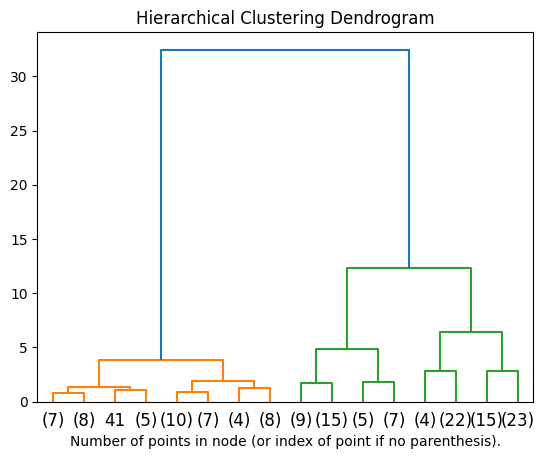

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris

def plot_dendrogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [455]:
if counts_tfidf is not None:
	cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(len(files), len(files))
	cs
else:
	print("counts_tfidf is None. Cannot compute cosine similarity.")
	cs = None

In [456]:
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage='ward',
    compute_distances=True
).fit(X)
clustering.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [ ]:
plot_dendrogram(
    clustering, 
    orientation='right',
    labels=files,
    leaf_font_size=10,
    color_threshold=0.7 * max(clustering.distances_)
)
plt.title("Dendrogram klastrów (cosine, ward)", fontsize=16)
plt.xlabel("Odległość", fontsize=12)
plt.ylabel("Dokumenty", fontsize=12)
plt.gcf().subplots_adjust(left=0.65)
plt.savefig(f"./skupienia/cosine_ward.png")
plt.close()


In [458]:
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(len(files), len(files))
ed

array([[  0.        ,  11.18033989,  14.6628783 ,  16.09347694,
         42.36744033,  30.5450487 ,  45.16635916,  15.19868415,
        103.47463457,  15.5241747 ,  43.48562981,  33.57082066,
         37.14835124,  51.00980298,  31.82766093,  33.37663854,
         74.76630257,  37.4566416 ,  44.74371464,  10.24695077,
         46.01086828, 178.51610572,  33.1662479 ,  51.4003891 ],
       [ 11.18033989,   0.        ,  14.49137675,  15.3622915 ,
         42.66145802,  30.59411708,  45.17742799,  15.55634919,
        103.75933693,  15.8113883 ,  43.56604182,  33.7934905 ,
         37.34969879,  50.96076922,  32.52691193,  33.66006536,
         74.79973262,  37.52332608,  44.82186966,  11.22497216,
         46.17358552, 179.2958449 ,  33.39161571,  51.50728104],
       [ 14.6628783 ,  14.49137675,   0.        ,  17.02938637,
         43.93176527,  32.80243893,  46.57252409,  19.33907961,
        103.88455131,  19.6977156 ,  45.23273151,  35.77708764,
         39.05124838,  52.31634544,  3

In [459]:
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='complete',
    compute_distances=True
).fit(ed)
clustering.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0])

In [460]:
plot_dendrogram(
    clustering, 
    labels = files,
    orientation = 'right'
)
plt.gcf().subplots_adjust(left=0.65)
plt.savefig(f"./skupienia/euclidean_complete.png")
plt.close()

7. n-gramy

In [461]:
if not os.path.exists("./ngramy"):
    os.mkdir("./ngramy")

In [462]:
n=3
if not os.path.exists("./ngramy/{n}"):
    os.mkdir("./ngramy/{n}")

In [463]:
documents_tokenized = {}
for filename in documents:
    documents_tokenized[filename] = word_tokenize(documents[filename], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))

{
    "2GL.txt": [
        "ang",
        "secondgeneration",
        "language",
        "język",
        "druga",
        "generacja",
        "termin",
        "oznaczać",
        "język",
        "rodzina",
        "asembler",
        "język",
        "spełniać",
        "następujący",
        "warunek",
        "koda",
        "czytać",
        "pisany",
        "programista",
        "móc",
        "uruchomić",
        "komputer",
        "musieć",
        "przekonwertować",
        "koda",
        "maszynowy",
        "specyficzny",
        "dana",
        "maszyna",
        "koda",
        "specyficzny",
        "dana",
        "platforma",
        "procesor",
        "język",
        "druga",
        "generacja",
        "zazwyczaj",
        "używać",
        "kernelach",
        "sterownik",
        "urządzenie",
        "używać",
        "wymagać",
        "intensywny",
        "przetwarzanie",
        "dana",
        "gra",
        "program",
        "edycja",
        "wide

In [464]:
n = 3
if not os.path.exists(f"./ngramy/{n}"):
    os.mkdir(f"./ngramy/{n}")

In [465]:
for filename in documents_tokenized:
    n_grams = pd.Series(ngrams(documents_tokenized[filename], n)).value_counts()
    n_grams[:5].plot.barh()
    plt.gcf().subplots_adjust(left=0.45)
    plt.savefig(f"./ngramy/{n}/{filename.replace('.txt', '.png')}")
    plt.close()


In [466]:
texts = ' '.join(docs['content']).split(" ")
n_grams = pd.Series(ngrams(texts, n)).value_counts()
n_grams[:15].plot.barh()
plt.gcf().subplots_adjust(left=0.45)
plt.savefig(f"./ngramy/{n}/all.png")
plt.close()